# Application of sensor identification algorithm on NIST PV system data

Bennet Meyers
8/7/20

NIST provides data from a collection of fully intrumented and documented arrays installed at their Maryland campus. In this notebook, we apply the proposed sensor identifcation algorithm on data from NIST. The data is publically available [here](https://doi.org/10.18434/M3S67G), and documentation of the systems is provided [here](http://dx.doi.org/10.6028/NIST.TN.1896). In preparation for this work, I downloaded the available data, which is provided in daily CSV files cover a time span of 4 years, seperated by system (ground, canopy, roof, and the two meterological stations). I extracted the power and irradiance columns from these 6937 individual CSV files, and combined them to generate a single table spaning four years. The resulting `pickle` file is about 1.1GB in size, and is available from [my personal OneDrive](https://office365stanford-my.sharepoint.com/:u:/g/personal/bennetm_stanford_edu/EZ6bR4CFT8BJoa6NHG8y6jEBnGwR5IKf7W0CTic-RCph-g?e=8VoEj3).

The proposed algorithm is based on minimizing the cross-validation error on a linear model between sensor candidates and a given PV production signal. The production signal can come from any number of sources, and is generally an AC or DC power or current measurement at some point in the PV system. This could be 

 - Module level
 - String level
 - Combiner box level
 - Inverter level
 - Site/aggregate meter level
 
The approach makes absolutely no assumptions about about PV module or system performance models, which has a number of benefits. First, this makes the technique broadly applicable, including situations where it is not possible to construct a performance model because the necessary metadata is not available. Second, we can apply the techniqe to data streams that would be difficult to model, such as aggregated power from multiple roof pitches or systems experiencing shading.

## Notebook setup and data loading

This notebook currently requires the most recent version of `solar-data-tools` to run, available [here](https://github.com/slacgismo/solar-data-tools/).

In [24]:
%load_ext autoreload
%autoreload 2
#Standard Imports
import pandas as pd
from glob import glob
from time import time
# Solar Data Tools imports
from solardatatools import DataHandler
from solardatatools.sensor_identification import SensorIdentification

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [25]:
df = pd.read_pickle('NIST_all_power_and_irradiance.pkl')

In [26]:
dh = DataHandler(df)

View the columns of the combined data table. I'm using a `MultiIndex` to keep track of the source table for each column ([see here](https://pandas.pydata.org/pandas-docs/stable/user_guide/advanced.html)).

In [27]:
df.columns

MultiIndex([(  'roof',          'Pyra1_Wm2_Avg'),
            (  'roof',          'Pyra2_Wm2_Avg'),
            (  'roof',          'Pyra3_Wm2_Avg'),
            (  'roof',          'Pyra4_Wm2_Avg'),
            (  'roof',          'Pyra5_Wm2_Avg'),
            (  'roof',          'Pyra6_Wm2_Avg'),
            (  'roof',          'Pyra7_Wm2_Avg'),
            (  'roof',          'Pyra8_Wm2_Avg'),
            (  'roof',       'RefCell1_Wm2_Avg'),
            (  'roof',       'RefCell2_Wm2_Avg'),
            (  'roof',       'RefCell3_Wm2_Avg'),
            (  'roof',          'InvPDC_kW_Avg'),
            (  'roof',          'InvPAC_kW_Avg'),
            (  'roof',   'SEWSPOAIrrad_Wm2_Avg'),
            (  'roof',      'ShuntPDC_kW_Avg_1'),
            (  'roof',      'ShuntPDC_kW_Avg_2'),
            (  'roof',      'ShuntPDC_kW_Avg_3'),
            (  'roof',      'ShuntPDC_kW_Avg_4'),
            (   'WS2',          'Pyrh2_Wm2_Avg'),
            (   'WS2',         'Pyrad2_Wm2_Avg'),


Seperate out power and irradiance columns.

In [29]:
pow_cols = [item for item in df.columns if '_Wm2_' not in item[1]]
irr_cols = [item for item in df.columns if '_Wm2_' in item[1]]

In [31]:
len(irr_cols)

40

## Analysis 1: Combiner Box 4 on Ground System

We take one of the combinerbox DC power measurements from the ground system at the PV production signal. We will apply the sensor identification algorithm to all columns that contain measurements in Watts per square-meter. There are 40 such columns available.

In [32]:
len(irr_cols)

40

Start by running the `DataHandler` pipeline on the desired PV production signal, using the `extra_columns` keyword arguement to align and prepaire the candidate irradiance sensors.

I somewhat arbitrarily select the DC power measured at combiner box 4 on the ground mount system. These panels are split between the east side of row 2 and the west side of row 3 (counting from the south to the north). There are three POA irradiance sensors for this system: a Kipp & Zonen CMP-11 pyranometer, an IMT c-Si reference cell, and an Apogee SP-110. There is also a second CMP-11 measuring GHI. Additionally, the weather station, `WS_1`, has a reference cell at a 20° tilt, matching the tilt of the ground system. (There is also a second refcel at this station at a 18.4° tilt.)

In [33]:
dh.run_pipeline(power_col=('ground', 'ShuntPDC_kW_Avg_3'), extra_cols=irr_cols, fix_shifts=False)

total time: 17.75 seconds
--------------------------------
Breakdown
--------------------------------
Preprocessing              14.48s
Cleaning                   0.56s
Filtering/Summarizing      2.13s
    Data quality           0.58s
    Clear day detect       0.26s
    Clipping detect        0.24s
    Capacity change detect 1.05s
Extra Column Processing    0.59s


In [34]:
dh.report()

Length:                4.00 years
Capacity estimate:     30.23 kW
Data sampling:         1.0 minute
Data quality score:    92.2%
Data clearness score:  15.7%
Inverter clipping:     False
Time shifts corrected: None
Time zone correction:  None


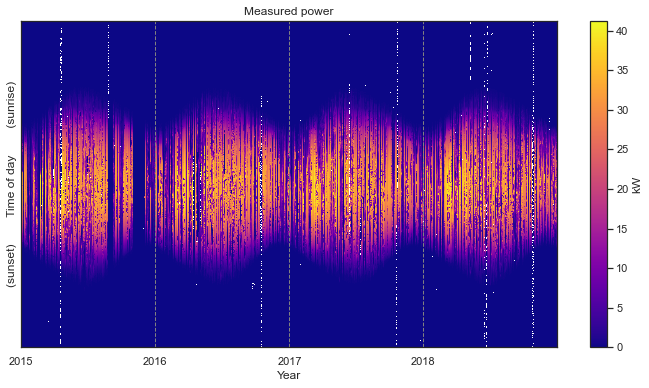

In [35]:
dh.plot_heatmap(matrix='raw');

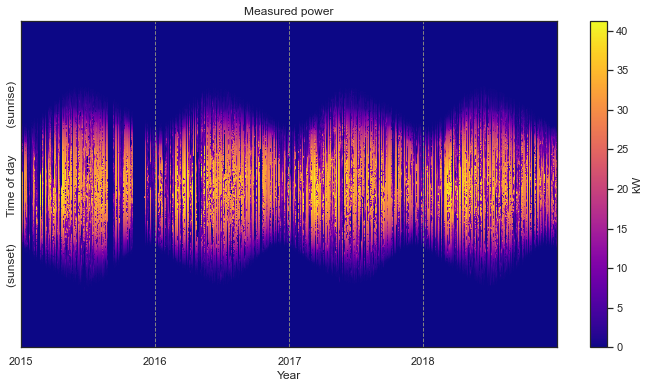

In [36]:
dh.plot_heatmap(matrix='filled');

Instantiate a `SensorIdentification` object, passing in our `DataHandler` instance.

In [37]:
si = SensorIdentification(dh)

Run the algorithm

In [38]:
ti = time()
si.identify()
tf = time()
msg = '{} sensors evaluated in {:.2f} minutes, {:.2f} seconds per sensor.'
print(msg.format(len(irr_cols), (tf - ti) / 60, (tf - ti) / len(irr_cols)))

40 sensors evaluated in 1.08 minutes, 1.62 seconds per sensor.


I'm currently doing 20 splits for the cross validation.

The selected sensor:

In [39]:
si.chosen_sensor

array(['ground', 'Pyra2_Wm2_Avg'], dtype='<U22')

The sensor/filter combinations with the lowest CV RMSE:

In [40]:
si.results_table.sort_values('cv-rmse').head(15)

,sensor,filter,corr,cv-rmse,cv-mbe
71,"(ground, Pyra2_Wm2_Avg)",clear,0.994587,1.422706,0.053675
72,"(ground, RefCell1_Wm2_Avg)",clear,0.993724,1.484591,-0.102534
31,"(ground, Pyra2_Wm2_Avg)",no_errors,0.988528,1.634078,0.022817
32,"(ground, RefCell1_Wm2_Avg)",no_errors,0.988144,1.656664,-0.071448
111,"(ground, Pyra2_Wm2_Avg)",cloudy,0.986247,1.668306,0.017709
112,"(ground, RefCell1_Wm2_Avg)",cloudy,0.986091,1.678116,-0.062897
68,"(WS1, RefCell5_Wm2_Avg)",clear,0.990837,1.792166,-0.236685
69,"(WS1, RefCell6_Wm2_Avg)",clear,0.990226,1.846327,-0.214292
73,"(ground, SEWSPOAIrrad_Wm2_Avg)",clear,0.990517,1.879223,0.032874
42,"(roof, Pyra3_Wm2_Avg)",clear,0.984870,2.390396,0.268891


The lowest RMSE was recorded for the POA K&Z pyranometer installed at the ground mount system under clear conditions. The POA IMT reference cell is second, with 9.6% higher RMSE. Additionally, these two sensors provide higher predictive power under cloudy and all conditions than any other sensor under clear conditions.

We find that the next best performing sensor is the reference cell at the weather station installed at 20°, follwed by the reference cell mounted at 18.4°, near the plane of the array. 

Interestingly, the weather station reference cells, which are far away on the opposite side of the NIST campus, beat the closer, cheaper Apogee pyranometer under clear sky conditions, but they lose under cloudy conditions (as well as all conditions, or "no_errors"). 

In [15]:
query = np.logical_or(
    si.results_table['sensor'] == ('ground', 'SEWSPOAIrrad_Wm2_Avg'),
    si.results_table['sensor'] == ('WS1', 'RefCell5_Wm2_Avg')
)
si.results_table[query].sort_values('cv-rmse')

,sensor,filter,corr,cv-rmse,cv-mbe
68,"(WS1, RefCell5_Wm2_Avg)",clear,0.990837,1.792166,-0.236685
73,"(ground, SEWSPOAIrrad_Wm2_Avg)",clear,0.990517,1.879223,0.032874
33,"(ground, SEWSPOAIrrad_Wm2_Avg)",no_errors,0.973012,2.504934,0.218948
113,"(ground, SEWSPOAIrrad_Wm2_Avg)",cloudy,0.966466,2.603083,0.256615
28,"(WS1, RefCell5_Wm2_Avg)",no_errors,0.964314,2.851968,-0.109406
108,"(WS1, RefCell5_Wm2_Avg)",cloudy,0.954340,3.009032,-0.084399


This appears to be evidence for the hypothesis that clear sky conditions are useful for finding sensors that match the plane of the array, while cloudy conditions held identify sensors that are closer to the system. I propose we call this "POA identification" and "location identification". Ideally, as in this case, there exists one or more sensors that are both close and in the plane of the array. However, if we only had `(WS1, RefCell5_Wm2_Avg)` and `(ground, SEWSPOAIrrad_Wm2_Avg)` to choose from, we may choose a different sensor depending on the specific analysis we wanted to carry out.

Here are the worst performing sensors:

In [16]:
si.results_table.sort_values('cv-rmse').tail(20)

,sensor,filter,corr,cv-rmse,cv-mbe
97,"(WS1, Pyrh1_Wm2_Avg)",cloudy,0.801485,6.240104,1.342483
92,"(WS2, Pyrh2_Wm2_Avg)",cloudy,0.801412,6.241283,1.343974
22,"(WS1, UVB_Wm2_Avg)",no_errors,0.823971,6.327131,-0.147705
21,"(WS1, UVA_Wm2_Avg)",no_errors,0.792737,6.539751,0.630924
93,"(WS2, Pyrad2_Wm2_Avg)",cloudy,0.711124,7.022623,0.619477
98,"(WS1, Pyrad1_Wm2_Avg)",cloudy,0.710672,7.027404,0.627042
61,"(WS1, UVA_Wm2_Avg)",clear,0.809663,7.749758,0.854782
62,"(WS1, UVB_Wm2_Avg)",clear,0.822686,7.848246,-0.050243
13,"(WS2, Pyrad2_Wm2_Avg)",no_errors,0.653388,8.108780,0.831801
18,"(WS1, Pyrad1_Wm2_Avg)",no_errors,0.652401,8.118217,0.839876


All of these are sensors that we would not expect to be good linear predictors of system power output—diffuse sensors, beam sensors, UV sensors, and IR sensors. Let's exclude these from future analysis.

In [17]:
irr_cols_reduced = [item for item in irr_cols if
                    np.all([e not in item[1] for e in ['UV', 'Pyrg', 'Pyrad', 'Pyrh']])]

# Analysis 2: AC inverter output of roof system

In [18]:
dh.run_pipeline(power_col=('roof', 'InvPAC_kW_Avg'), extra_cols=irr_cols_reduced, correct_tz=False)
dh.report()

total time: 15.47 seconds
--------------------------------
Breakdown
--------------------------------
Preprocessing              12.15s
Cleaning                   1.28s
Filtering/Summarizing      1.79s
    Data quality           0.36s
    Clear day detect       0.23s
    Clipping detect        0.26s
    Capacity change detect 0.94s
Extra Column Processing    0.25s
Length:                3.00 years
Capacity estimate:     48.04 kW
Data sampling:         1.0 minute
Data quality score:    93.2%
Data clearness score:  20.5%
Inverter clipping:     False
Time shifts corrected: False
Time zone correction:  None


In [19]:
ti = time()
si = SensorIdentification(dh)
si.identify()
tf = time()
msg = '{} sensors evaluated in {:.2f} minutes, {:.2f} seconds per sensor.'
print(msg.format(len(dh.extra_matrices), (tf - ti) / 60, (tf - ti) / len(dh.extra_matrices)))

31 sensors evaluated in 0.91 minutes, 1.76 seconds per sensor.


In [20]:
si.chosen_sensor

{'clear': array(['roof', 'Pyra3_Wm2_Avg'], dtype='<U20'),
 'cloudy': array(['roof', 'RefCell1_Wm2_Avg'], dtype='<U20'),
 'no_errors': array(['roof', 'RefCell1_Wm2_Avg'], dtype='<U20')}

Here we get an interesting result. Our algorithm has found that three different sensors minimize the RMSE for the three different filtering schemes. Let's look at the 15 best sensor/filter combinations to see if we can figure out what's going on.

In [21]:
si.results_table.sort_values('cv-rmse').head(15)

,sensor,filter,corr,cv-rmse,cv-mbe
33,"(roof, Pyra3_Wm2_Avg)",clear,0.993771,2.277563,-0.037752
39,"(roof, RefCell1_Wm2_Avg)",clear,0.993204,2.321409,-0.234391
8,"(roof, RefCell1_Wm2_Avg)",no_errors,0.989369,2.486109,-0.133763
2,"(roof, Pyra3_Wm2_Avg)",no_errors,0.989414,2.499336,0.004377
70,"(roof, RefCell1_Wm2_Avg)",cloudy,0.987698,2.517260,-0.102639
42,"(roof, SEWSPOAIrrad_Wm2_Avg)",clear,0.993940,2.543924,0.315740
64,"(roof, Pyra3_Wm2_Avg)",cloudy,0.987443,2.554651,0.020068
47,"(WS1, RefCell2_Wm2_Avg)",clear,0.991565,2.573007,-0.325148
36,"(roof, Pyra6_Wm2_Avg)",clear,0.991795,2.705649,0.250488
51,"(WS1, RefCell6_Wm2_Avg)",clear,0.991245,2.723172,-0.722742


Right off the bat, we see that the three chosen sensors are in tight competition. According to the documentation, all three are POA sensors, and indeed all three under clear conditions beat out all other sensor/filter combinations. Additionally, the RMSE values under clear conditions are within about 5% of each other. Note, however, that the best RMSE values are more than 35% larger than in the previous analysis. This is consistent with what we know from the documentation:

 - This signal was generated from PV panels spread across multiple combiner boxes and many rows of roof-mount racking, with some variation in orientations.
 - The rooftop system experiences larger shading and reflection impacts than the ground mount system.
 - The AC power signal will have additional losses not captured in a linear irradiance model.
 
We would expect all these impacts to make it more difficult to find identify an irradiance sensor with good predictive power in a linear model, and our results support that.

We also find that the weather station sensor `(WS1, RefCell2_Wm2_Avg)` does okay under sunny conditions. This reference cell is mounted 10°, matching the nominal array tilt for this system.

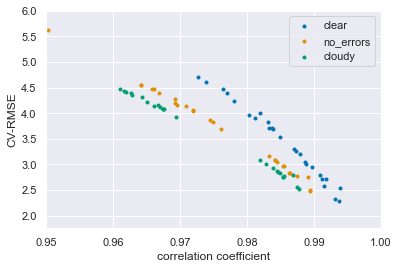

In [22]:
for f in set(si.results_table['filter']):
    qry = si.results_table['filter'] == f
    plt.scatter(si.results_table[qry]['corr'], si.results_table[qry]['cv-rmse'], marker='.', label=f)
plt.legend()
plt.xlim(0.95, 1)
plt.ylim(1.75, 6)
plt.xlabel('correlation coefficient')
plt.ylabel('CV-RMSE');

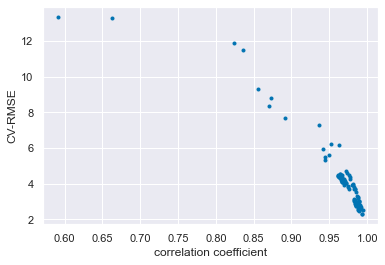

In [23]:
plt.scatter(si.results_table['corr'], si.results_table['cv-rmse'], marker='.', label=f)
# plt.xlim(0.95, 1)
# plt.ylim(1.75, 6)
plt.xlabel('correlation coefficient')
plt.ylabel('CV-RMSE');